# Problem 1.3 (Microtubule catastrophes I, 50 pts)


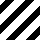
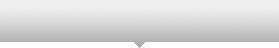
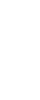
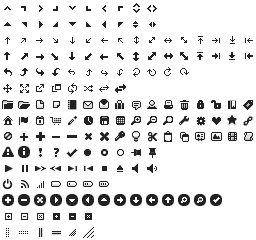
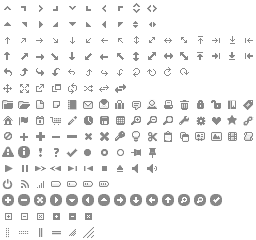
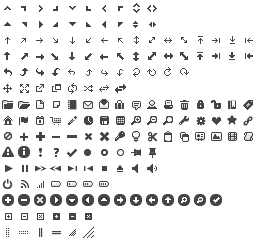
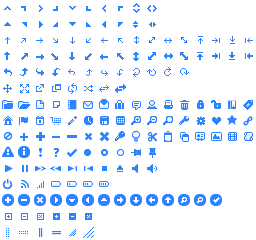
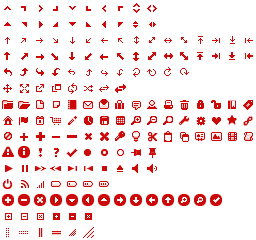
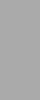
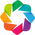
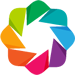
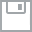
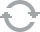
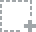
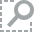
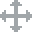
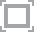
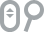

In [27]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.integrate

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 10, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

## Exercise 1.3a: Load data

In [28]:
# start by loading the data
df = pd.read_csv('data/gardner_et_al_2011_time_to_catastrophe_dic.csv',comment='#')
df.columns = ['labeled', 'unlabeled']

In [29]:
# Inspect data
df

,labeled,unlabeled
0,470,355
1,1415,425
2,130,540
3,280,265
4,550,1815
5,65,160
6,330,370
7,325,460
8,340,190
9,95,130


## Exercise 1.3b: Tidy data

"I would argue that these data are not tidy. Why?" - Justin Bois  
Each observation should be given a separate row. This is especially true in this case, where the data structure implies that the labeled and unlabeled tubulin measurements are paired in some way, but in fact they are just two separate observations.

We should create a table with columns:

Labeled? | Time (s)

This is easy (even without pd.melt), we can pull out column 'labeled' and add it to our new tidy df (with value True for "Labeled?") and then do the same for column 'unlabeled' (with value False for 'Labeled?').

In [30]:
# Initialise df with labeled observations
df_tidy = pd.DataFrame({'labeled': True, 'time': df['labeled']})

# Add unlabeled observations
df_tidy = df_tidy.append(pd.DataFrame({'labeled': False, 'time': df['unlabeled']}))

# Drop rows with NaN
df_tidy = df_tidy.dropna()

# Inspect again
pd.DataFrame.head(df_tidy)

,labeled,time
0,True,470
1,True,1415
2,True,130
3,True,280
4,True,550


## Exercise 1.3c: Histograms

Let's begin by making a normed histogram with 20 bins for each of the labeled and unlabeled tubes. 

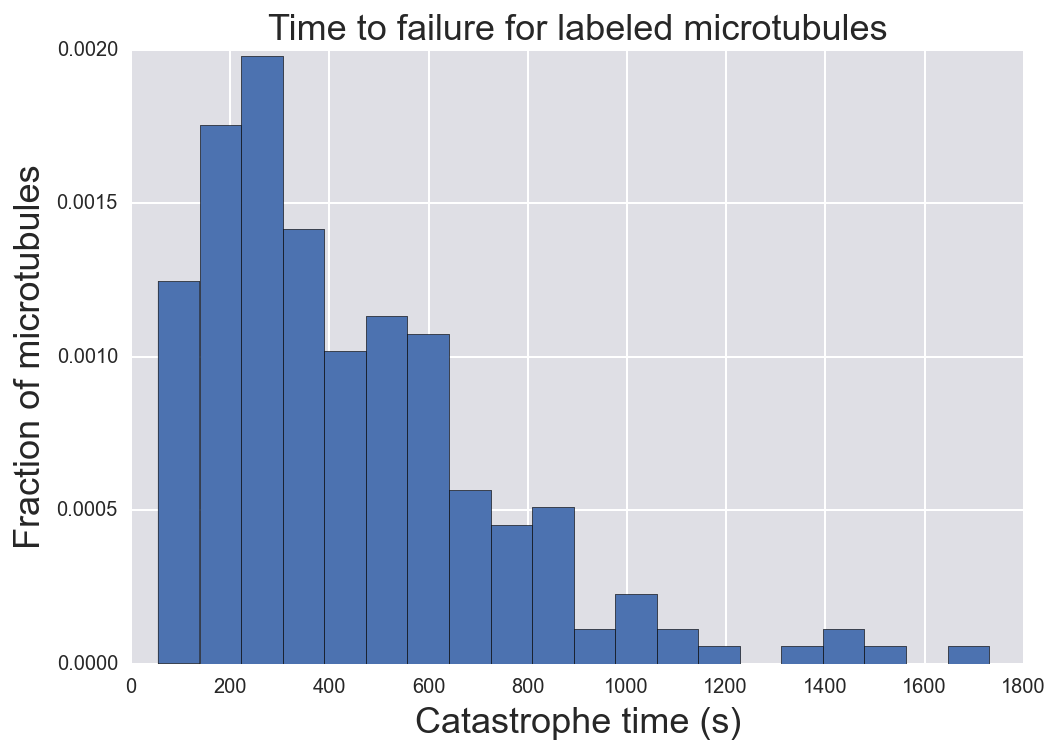

In [31]:
# Make a histogram for the labeled microtubules
# df_tidy['labeled'] happens to already give the list we want, but for clarity here
# we are explicitly making a list of the indices of observations where labeled == True
labeled_inds = (df_tidy['labeled'] == True)

# Plot
_ = plt.hist(df_tidy[labeled_inds]['time'], bins=20, normed=True)
plt.xlabel('Catastrophe time (s)')
plt.ylabel('Fraction of microtubules')
plt.title('Time to failure for labeled microtubules')

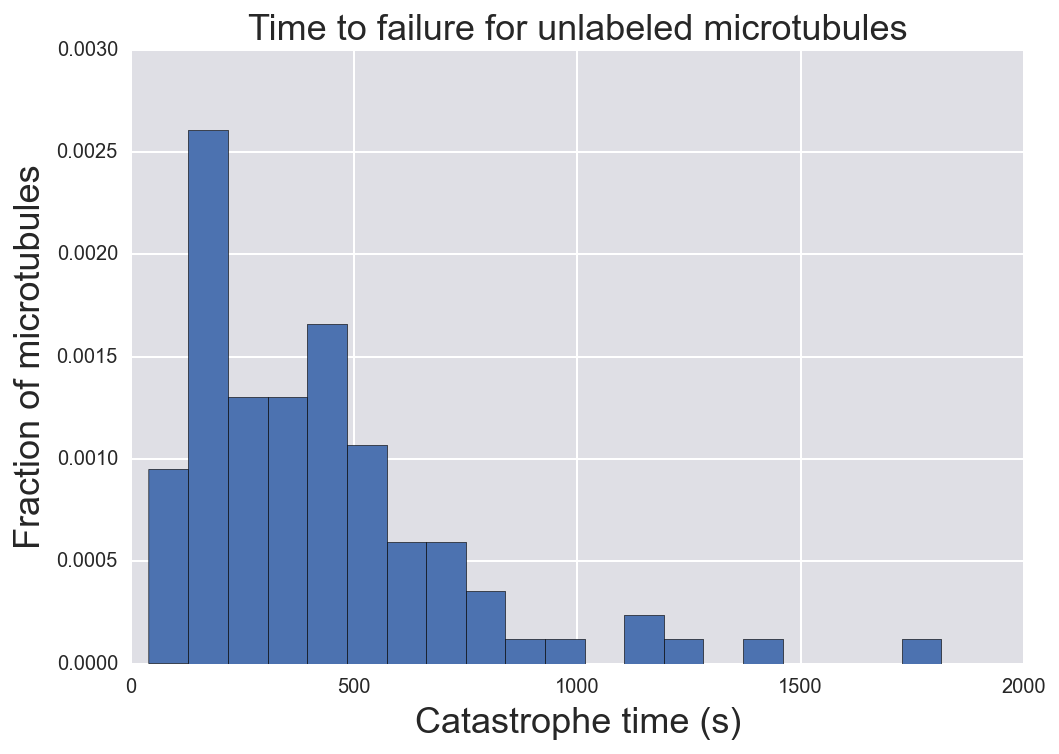

In [32]:
# make a histogram for the unlabeled microtubules
unlabeled_inds = (df_tidy['labeled'] == False)
# Plot
_ = plt.hist(df_tidy[unlabeled_inds]['time'], bins=20, normed=True)
plt.xlabel('Catastrophe time (s)')
plt.ylabel('Fraction of microtubules')
plt.title('Time to failure for unlabeled microtubules')

It would be easier to compare the histograms if they were on the same axis. Here, it becomes important that the histograms are normed so that bar heights can be compared directly without regard for the number of labeled/unlabeled tubes. We are directly comparing between labeled and unlabeled microtubules, and we want to answer questions like "do labeled microtubules have a longer time before catastrophe?". As there are a different number of observations of each type, it is easier if they are normed so we are looking at fractions of observations rather than absolute numbers. 

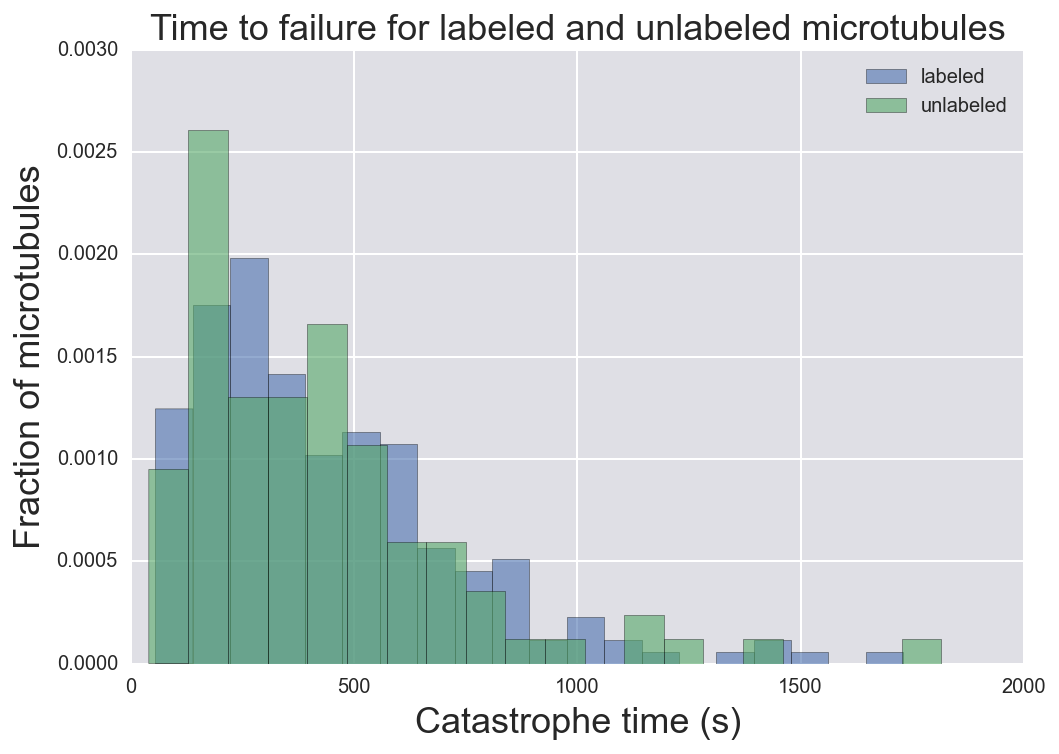

In [33]:
# Nicer to overlay labeled and unlabeled microtubules on same histogram
_ = plt.hist(df_tidy[labeled_inds]['time'], bins=20, normed=True, alpha=0.6)
_ = plt.hist(df_tidy[unlabeled_inds]['time'], bins=20, normed=True, alpha=0.6)

plt.xlabel('Catastrophe time (s)')
plt.ylabel('Fraction of microtubules')
plt.title ('Time to failure for labeled and unlabeled microtubules')
plt.legend (['labeled', 'unlabeled'])

The bins are not the same size because there is a greater range of times in the labeled condition than the unlabeled condition, so it is difficult to compare the data. Let's fix that by specifying identical, evenly spaced bins for both histograms. Now we can see that the distributions are similar for labeled/ unlabeled. We've kept the number of bins to 20, as this seems to provide a good balance between smoothness and showing relevant information. We will show some other bin sizes later to support this.

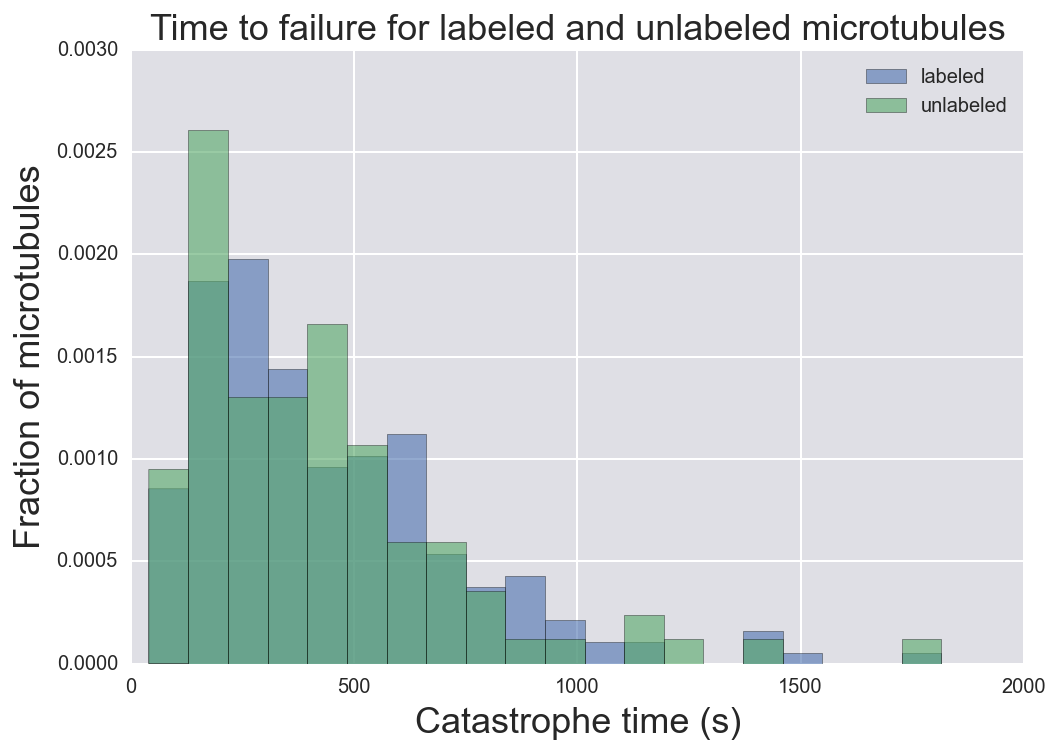

In [34]:
# Use np.linspace for equally spaced bins in range of data. The range we use is the whole range,
# including both labeled and unlabeled data, so that both have the same bin size.
# We pass an array of bin boundaries to plt.hist, so np.linspace num=21 gives 20 bins. 
_ = plt.hist(df_tidy[labeled_inds]['time'],
         bins=np.linspace(min(df_tidy['time']), max(df_tidy['time']), 21),
         normed=True,
         alpha=0.6)
_ = plt.hist(df_tidy[unlabeled_inds]['time'],
         bins=np.linspace(min(df_tidy['time']), max(df_tidy['time']), 21),
         normed=True,
         alpha=0.6)

plt.xlabel('Catastrophe time (s)')
plt.ylabel('Fraction of microtubules')
plt.legend(['labeled','unlabeled'])
plt.title ('Time to failure for labeled and unlabeled microtubules')

Let's try different bin widths. 10 bins is clearly too few, as now the histogram fails to capture the peak but instead appears to decrease almost monotically. 

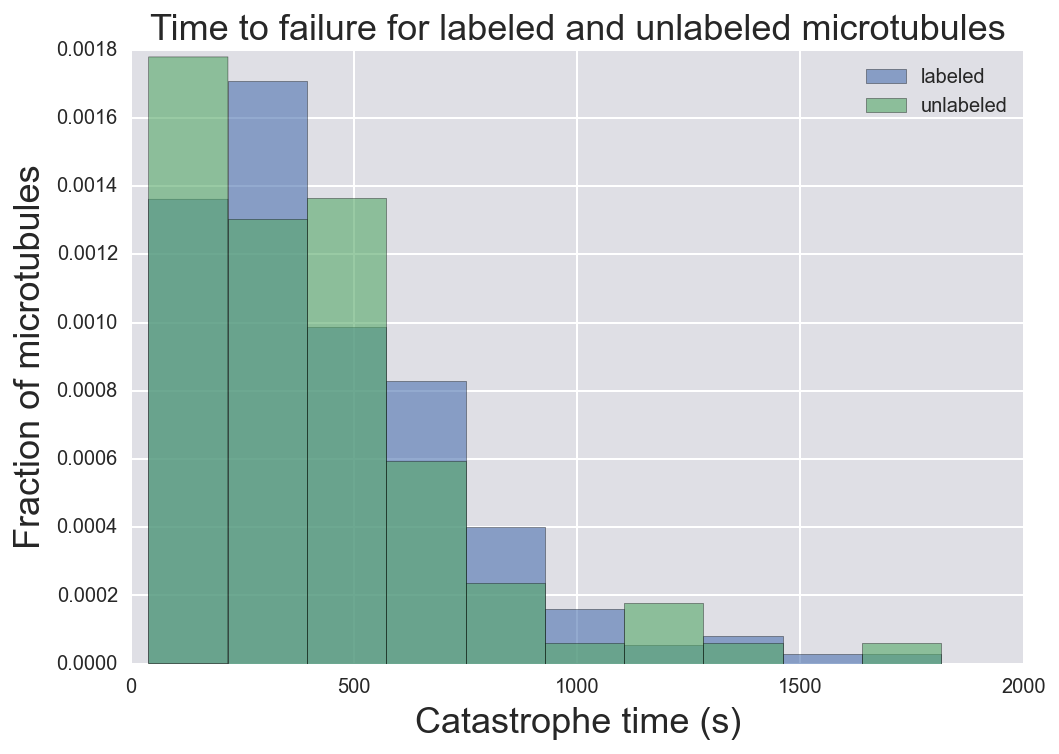

In [35]:
_ = plt.hist(df_tidy[labeled_inds]['time'],
         bins=np.linspace(min(df_tidy['time']), max(df_tidy['time']), 11),
         normed=True,
         alpha=0.6)
_ = plt.hist(df_tidy[unlabeled_inds]['time'],
         bins=np.linspace(min(df_tidy['time']), max(df_tidy['time']), 11),
         normed=True,
         alpha=0.6)

plt.xlabel('Catastrophe time (s)')
plt.ylabel('Fraction of microtubules')
plt.legend(['labeled','unlabeled'])
plt.title ('Time to failure for labeled and unlabeled microtubules')

With 50 bins, the histogram becomes noisy and jagged. 

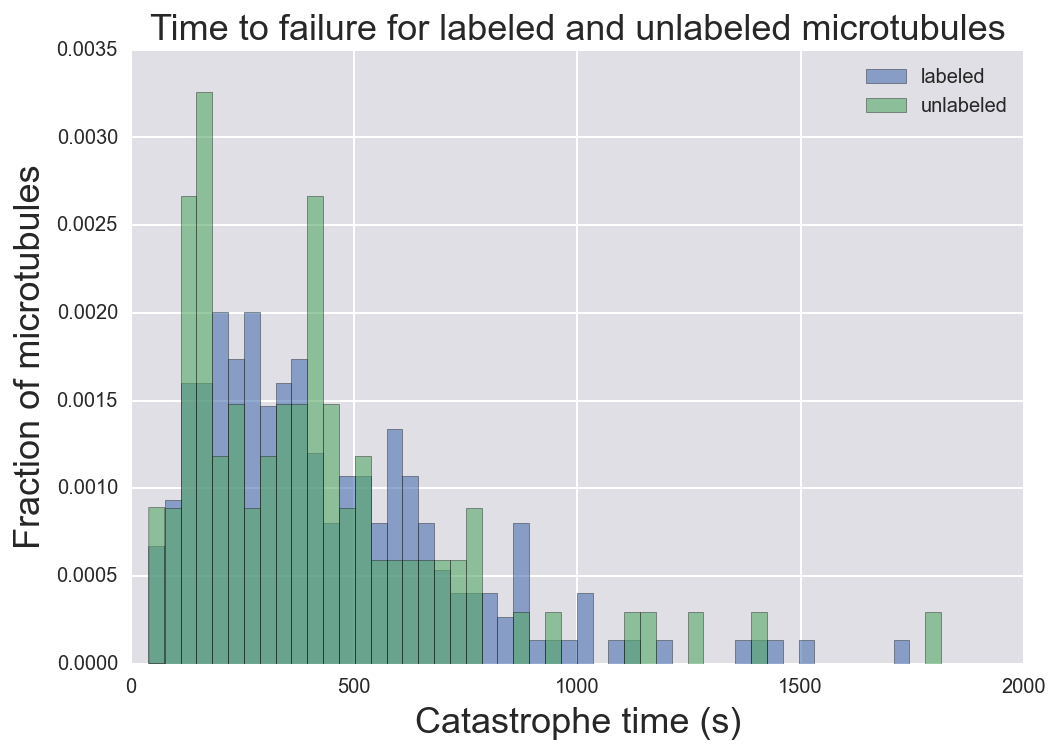

In [36]:
# Try different bin widths. 50 bins give more information than 20 but is busier and hard to read.
_ = plt.hist(df_tidy[labeled_inds]['time'],
         bins=np.linspace(min(df_tidy['time']), max(df_tidy['time']), 51),
         normed=True,
         alpha=0.6)
_ = plt.hist(df_tidy[unlabeled_inds]['time'],
         bins=np.linspace(min(df_tidy['time']), max(df_tidy['time']), 51),
         normed=True,
         alpha=0.6)

plt.xlabel('Catastrophe time (s)')
plt.ylabel('Fraction of microtubules')
plt.legend(['labeled','unlabeled'])
plt.title ('Time to failure for labeled and unlabeled microtubules')

## Exercise 1.3d: Cumulative Histograms

Let's begin by making a cumulative histogram with the same 20 bins as before. 

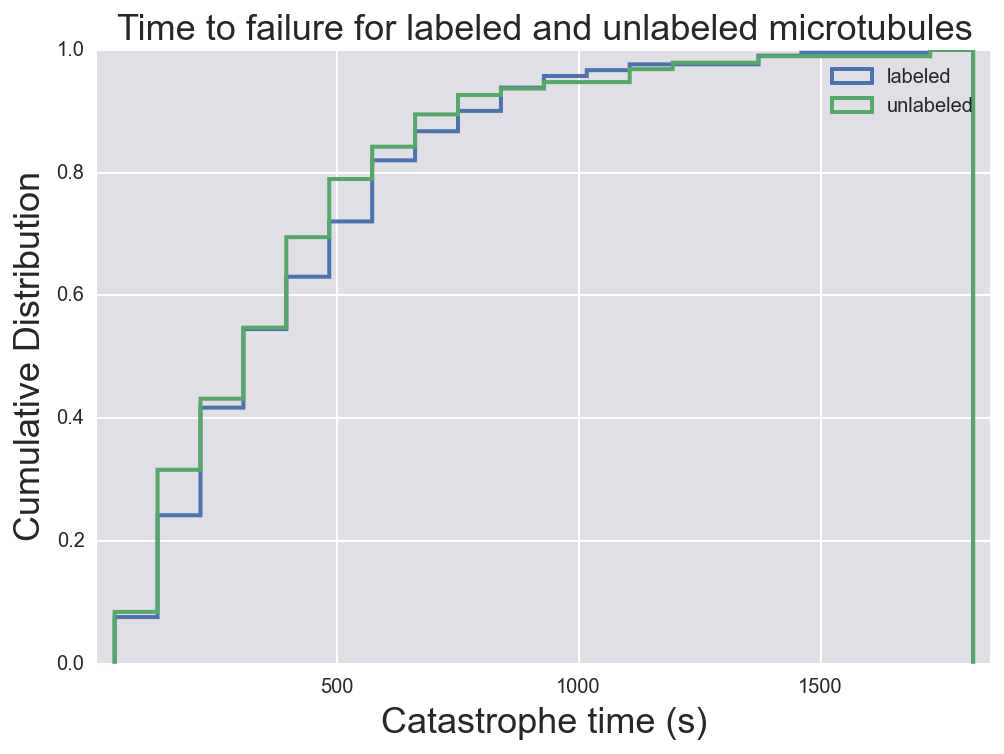

In [37]:
# make a cumulative histogram for the labeled and unlabeled microtubules
_ = plt.hist(df_tidy[labeled_inds]['time'],
         bins=np.linspace(min(df_tidy['time']), max(df_tidy['time']), 21),
         normed=True,
         histtype='step',
         cumulative=True,
         linewidth=2.0)
_ = plt.hist(df_tidy[unlabeled_inds]['time'],
         bins=np.linspace(min(df_tidy['time']), max(df_tidy['time']), 21),
         normed=True,
         histtype='step',
         cumulative=True,
         linewidth=2.0)
plt.xlabel('Catastrophe time (s)')
plt.ylabel('Cumulative Distribution')
plt.legend(['labeled','unlabeled'])
# Doesn't make sense to extend y range beyond 1 for cumulative, normed histogram.
plt.ylim(0,1)
plt.margins(x=0.02, y=0.02)
plt.title ('Time to failure for labeled and unlabeled microtubules')

## Exercise 1.3e: Imitating Figure 2a

Figure 2a of the Gardner, Zanic, et al. paper appears to plot the total number of failures up to that timepoint at each timepoint in the data. To do that, we will first sort the failure times, then get the number of failures at each time, and finally do a cumulative sum of the failure counts. 

(0, 1.05)

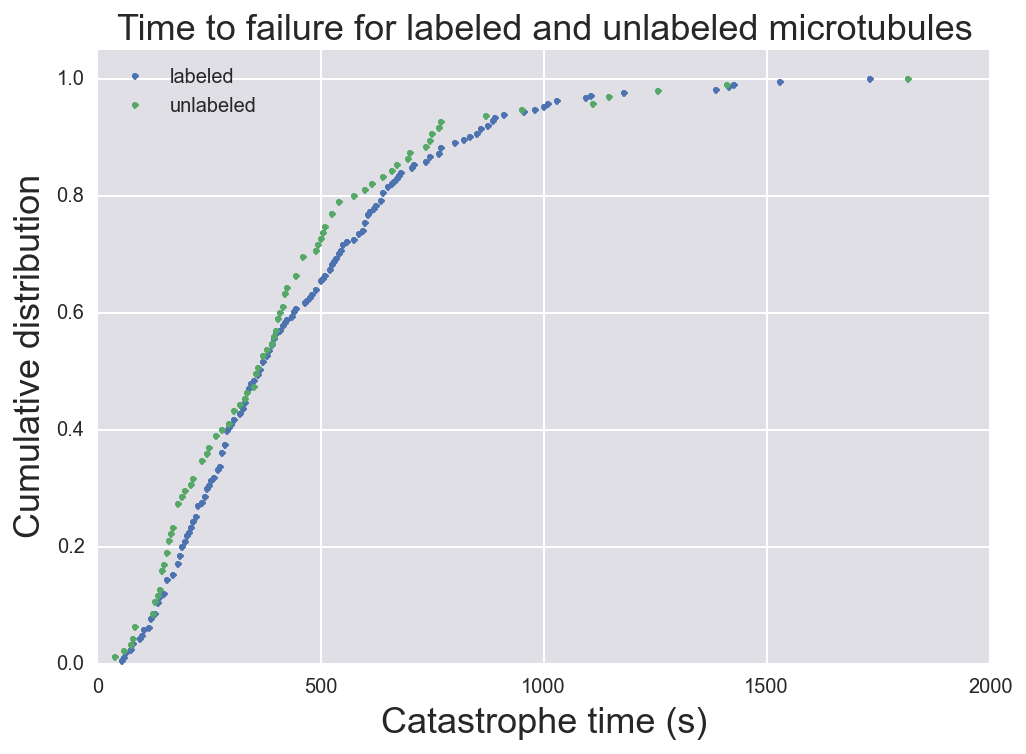

In [38]:
# Make a cumulative histogram for the labeled and unlabeled microtubules with no binning. 
# Data is rounded to nearest second. 
# First, sort the failure times
labeled_times = df_tidy[labeled_inds]['time'][:] 
pd.Series.sort(labeled_times,inplace=True)
unlabeled_times = df_tidy[unlabeled_inds]['time'][:]
pd.Series.sort(unlabeled_times,inplace=True)
# then, find the cumulative number at each time
for times in [labeled_times, unlabeled_times]:
    counts = times.value_counts()
    n_failed = []
    n = 0 # cumulative number of failures
    for t in sorted(counts.index):
        n += counts[t]
        n_failed.append(n)
    # norm the counts
    n_failed = [float(nf)/float(n) for nf in n_failed] 
    # plot
    plt.plot (sorted(counts.index), n_failed,'.')
plt.xlabel('Catastrophe time (s)')
plt.ylabel ('Cumulative distribution')
plt.legend (['labeled','unlabeled'],loc='best')
plt.title ('Time to failure for labeled and unlabeled microtubules')
plt.ylim(0,1.05)

## Exercise 1.3f: Analysis

The plot in part e contains more information than the plot in part d without being more difficult to interpret. For a multimodal distribution, it may be helpful to have a histogram that more clearly shows the multiple modes.  